In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# MNIST Dataset

We will be working with the MNIST dataset which contains 70,000 small images of digits handwritten.

In [2]:
#Import the dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
#Lets build our array of features and label. X will be our features and Y will be our labels
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

There are 70000 examples with 784 features the 784 features represents the pixels which are 28 x 28. 

This is split by pixel color intensity fomr 0 to 255. With 0 being white and 255 being black

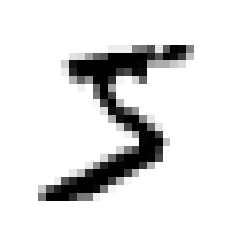

In [5]:
#Lets print out a value
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap="binary")
plt.axis("off")
plt.show()

In [6]:
#Building the label data converting it into a multi d array
y = y.astype(np.uint8)

This is a example of the a training feature. We noticed it is a grey scaled image.

Now we are going to create a training and test dataset.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a binary classifer

We are going to use just one label which is the number 5

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
#Using a SDG or Stochastic Gradient Descent Classifer
from sklearn.linear_model import SGDClassifier

In [10]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

We saw above that we did predict 5 when we trained 5. 

# Measuring accuracy with Cross-validation

A good way to evaluate a model is to use cross validation. Cross  validation is when we split the dataset into small batches and evalulate the model. This way we can see how the model is performing across different batches

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [13]:
skfolds = StratifiedKFold(n_splits=3)

In [14]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


What is going on above is that we are using StratifiedKFold to do split the training data into 3 sets.

Then on each set we test and see how accurate our predictions are. So our first roudn of predictions had a 95.03% accuracy but towards the end we have 96.04%.

We can now use cross_val_score to get the cross validation score

In [15]:
from sklearn.model_selection import cross_val_score

In [16]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Important to know that 96% ration of correct predictions does not mean it is actually good. If the majority of the data is not 5 then we are predicting not 5 most of the time yes we will be right

In [17]:
from sklearn.base import BaseEstimator

In [18]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1),dtype=bool)

The above Never5 Classifer class will basically just tell us if we never predict 5

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

We get a 90% accuracy if we always say not 5. That is because most of the dataset is probably not a 5

## Measuring performance with a confusion matrix

In [20]:
from sklearn.model_selection import cross_val_predict

In [21]:
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=5)

In [22]:
from sklearn.metrics import confusion_matrix 

In [23]:
confusion_matrix(y_train_5,y_train_pred)

array([[53115,  1464],
       [  916,  4505]])

The above array is called a Confusion Matrix. Where the number 53115 is the True Positive Number. This means the number of numbers correctly classify as non- fives. The number 1464 is known as the false positives which is the number of classes incorrectly predicted as 5.

The number 916 is the false negatives. This is where we predicted not a 5 but they were actually fives. 

The number 4505 is the True Negative which is when we predicted non-fives we got it right. Ideally we want to have only True Positives and True Negatives. 

Ideally we want to use 1 metric to look at success. We have 1 metric called Precision.

Precision = True Postive / (True Positive + False Positive)

The way to think of Precision is by saying we prediced that the class is 1 and it is 1. So we have 1/1 = 100%.

The limit with this approach is that it ignores all but 1 instance. 

So we use another one called Recall.

Recall = True Postitive / (True Positive + False Negative)

This is the ratio of positive instances that ar ecorrectly detected by the classifier. 

In [24]:
#Lets see this in action
from sklearn.metrics import precision_score, recall_score

In [25]:
precision_score(y_train_5,y_train_pred)

0.7547327860613168

In [26]:
recall_score(y_train_5,y_train_pred)

0.8310274857037447

So what does the above mean. Well the precision score says that We predicted four values but three values where 5s and the other was not a 5. 

The recall score says we predicted five values. Three values where 5s (TP) but we also missed two 5s (FN). 

<img src="284.png">

Use this image as a reference.

There is a another metric called the F1 Score which is a way to combine precision with recall. The F1 score is the harmonic mean of precision and recall.

<img src = "f1.png">

In [27]:
#Lets use this metric
from sklearn.metrics import f1_score

In [28]:
f1_score(y_train_5,y_train_pred)

0.791044776119403

In some cases you may want a higher recall or precision. If you train a classifer to scan all YouTube videos and check that they are safe for kids. You want a classifer with a low recall and high precision because you want to catch all bad videos even if it includes some good ones. 

In some cases you may want a higher recall and a lower precision say if your classifer is meant to detect shoplifters. You want to make sure you catch all shop lifters even that you will get a few false alerts. 

The SDG classifer computes it's score based on the decision function. If the score is higher than the threshold it assigns the instance to the postive class if not than negative. 

In [29]:
#Using Scikit decision function
y_scores = sgd_clf.decision_function([some_digit])

In [30]:
y_scores

array([2164.22030239])

What we have above is the score and if the score is higher than our threshold then it is postive. For SGDClassifiers the threshold is a number greater than 0.

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [33]:
y_some_digit_pred

array([ True])

We can set our own classifiers

In [35]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

So how do you decide a threshold.

In [36]:
#Use cross validation to get all the scores in teh training set but return only the decision_function
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

In [37]:
from sklearn.metrics import precision_recall_curve

In [38]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

In [41]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label='Precision',linewidth=2)
    plt.plot(thresholds,recalls[:-1],"g--",label="Recall",linewidth=2)
    plt.legend(loc="center right",fontsize=16)
    plt.xlabel("Threshold",fontsize=16)
    plt.grid(True)
    plt.axis([-50000,50000,0,1])

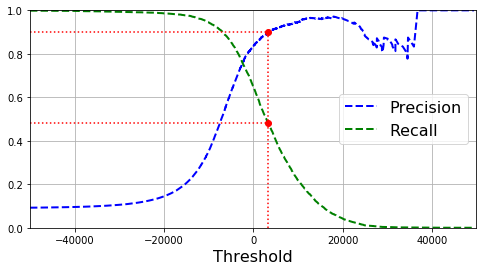

In [44]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
#save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

We can see that has precision goes up recall goes down. We see the different thresholds and the impact it plays.

We can also plot the precision against the recall on 1 graph.

In [46]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [48]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [49]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

Remember a high precision is not always good if the recall is too low. 

There is a another metric called the receiver operating characteristics (ROC) curve. It plots the true positive rate which is also the recall against the false positive rate. False positive rate is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - the true negative rate which is also the ratio of the negative instances that are correctly classified as negative. 

In [50]:
#Plot the curve
from sklearn.metrics import roc_curve

In [51]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [52]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)      

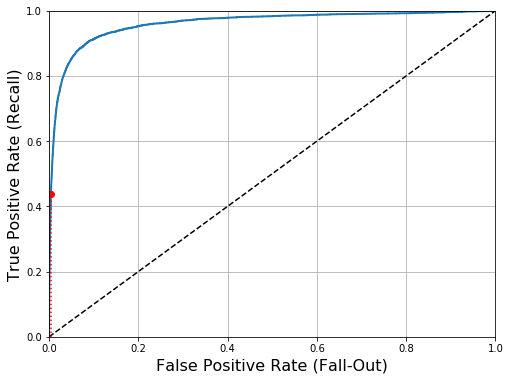

In [54]:
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
#save_fig("roc_curve_plot")                         # Not shown
plt.show()

We want the blue line as far as possible from the dotted line which is our False Positive rate. The closer it is to the dotted line it means are doing more false positives

A metric to use is the Area Under the Curve or AUC. This is the difference space into FPR and the TPR. If the AUC is equal to 1 then it is perfect. We can print out the score

In [55]:
from sklearn.metrics import roc_auc_score

In [56]:
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

Lets compare a Random Foreest Classifier against the SDG Classifer

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

In [60]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

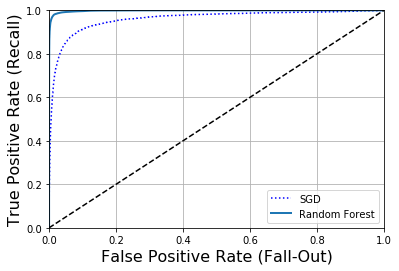

In [61]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()

In [62]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

# Multiclass Classification

You know that you can do a binary class but it is also possible to do a multi class multiclassification.
Some algorithms are better for multi-class but you can do it with any time of classifier. 

One method is: one-verus-the-rest or one-verus-all.

You can create a syustem that can classify teh digit images into 10 classes form 0 to 10. And you train 10 binary classifers one for each digit. Then you u se the decision score from each classifier and pick the one that gives you the highest score. 

Another option is to train a binary classifier for every pair of digits for example distinguishing 0 and 1, then 0 and 2s and 1s and 2s. This is called one version one strategy.  So if you have N classes you need to train Nx(N-1) /2 classifers. 

Lets use a Support Vector Machine 

In [63]:
from sklearn.svm import SVC

In [64]:
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

What happened above is that sklearn used the one vs one strategy. lets print out the decision function.

In [65]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

The score 9.3 is the hinhest score meaing that is the one corresponding to the class 5

In [66]:
np.argmax(some_digit_scores)

5

In [67]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

You can control if Sklearn uses OneVsOne or OneVsRest

In [68]:
from sklearn.multiclass import OneVsRestClassifier

In [69]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [71]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [73]:
#Using just SDG
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

The SDG classifer does not actually need to run OvR or OvO beause the classifers can directly classify instances into multiple classes.  The decision functions now returns 1 value per class

In [74]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [75]:
#Validating with cross validation
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [76]:
from  sklearn.preprocessing import StandardScaler

In [77]:
scaler = StandardScaler()

In [78]:
x_trained_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [82]:
cross_val_score(sgd_clf,x_trained_scaled,y_train,cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])